# My Favorite Pet

Goal:

To train 2 binary classification models: one for dogs and one for cats. And to combine them together to have a multiclass classification model.

In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential
import random
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [3]:
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d anirudhg15/mammals-classification
# !unzip /content/mammals-classification.zip

# Sources

- https://www.tensorflow.org/tutorials/images/classification

- https://www.kaggle.com/code/o07rohitjj/mammals-classification-with-efficientnet

- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

# Data Exploration

In [4]:
data_path = 'mammals'
mammals = [f.name for f in os.scandir(data_path) if f.is_dir()]
mammals

['cat', 'dog', 'bear', 'tiger', 'goat', 'wolf', 'horse', 'lion', 'elephant']

### Separate dog data

In [8]:
dog_root = data_path + '/dog/'
dog_url = [dog_root+dog for dog in os.listdir(dog_root)]
dog_data = [Image.open(dog) for dog in dog_url]

## Example of how to read the image as numpy array

In [9]:
dog_1 = Image.open(dog_url[1])
# "thumbnail" is to shrink the image wihile keeping the aspect ratio
dog_1.thumbnail((100, 100))
dog_1.show()

In [10]:
# "reduced" is to shrink the image resolution by dividing the given value
dog_1_re = dog_1.reduce((10, 10))
dog_1_re.show()

In [11]:
dog_0 = Image.open(dog_url[0])
# "resize" is to shrink the image to a given size
dog_0_r = dog_0.resize((180, 180), Image.ANTIALIAS)
dog_0_r.show()

/var/folders/pg/t33xxggd1cndkk5fsb62rs_40000gn/T/ipykernel_64048/305650333.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  dog_0_r = dog_0.resize((180, 180), Image.ANTIALIAS)


# Data Preparation

### Loading data into a pandas data frame with one column of file paths and one column of labels

In [12]:
direc = Path('mammals')
filepaths = list(direc.glob(r'**/*.jpg'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))


filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index=True, left_index=True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

img_df = img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,mammals/goat/00000015.jpg,goat
1,mammals/tiger/00000085.jpg,tiger
2,mammals/bear/00000071.jpg,bear
3,mammals/dog/00000046.jpg,dog
4,mammals/dog/00000025.jpg,dog


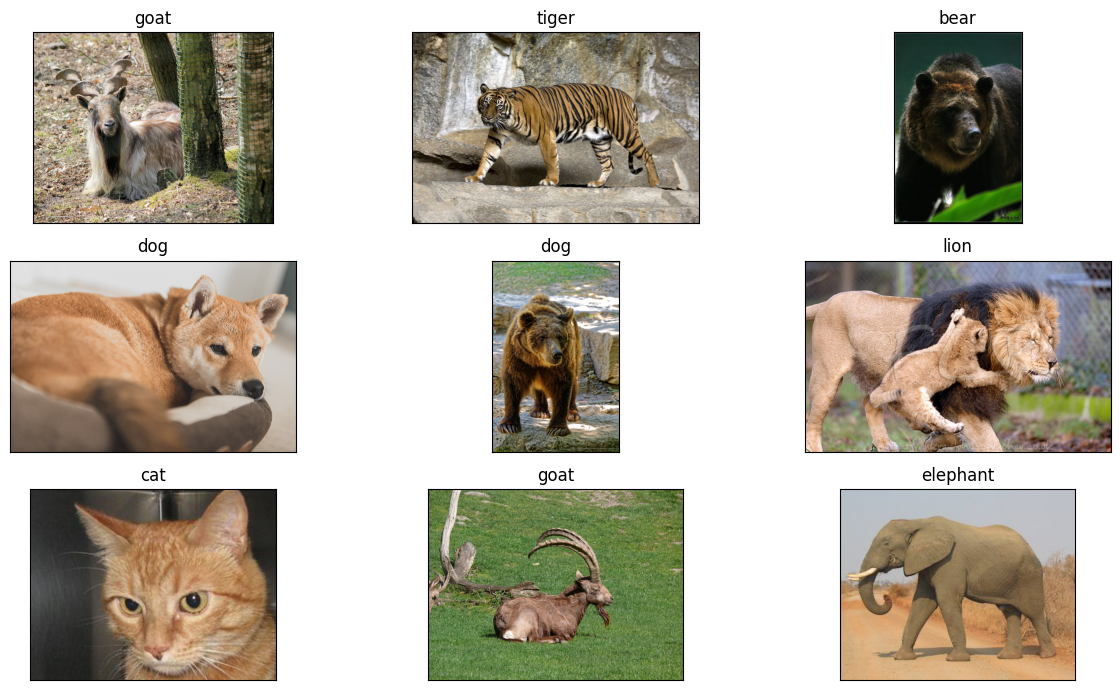

In [13]:
f, a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])

plt.tight_layout()
plt.show()

### Split training data

In [14]:
def divide_data(img_df, dog_or_cat='dog'):
    if dog_or_cat not in ['dog', 'cat']:
        raise ValueError("Invalid value for dog_or_cat. It should be either 'dog' or 'cat'.")
    main_animal_df = img_df[img_df.Labels==dog_or_cat]
    half = img_df.shape[0] // 2
    if dog_or_cat == 'dog':
        slice_animals = slice(0, half)
    else:
        slice_animals = slice(half, -1)
    all_animals_df = img_df[~img_df.Labels.isin(['dog', 'cat'])][slice_animals].sample(n = main_animal_df.shape[0], random_state=42)
    df = pd.concat([main_animal_df, all_animals_df]).sample(frac = 1, random_state=42)
    df['y'] = df.Labels == dog_or_cat
    return df

In [15]:
dog_train = divide_data(img_df, dog_or_cat='dog')
print(type(dog_train))
print('Training set size:', dog_train.shape)
print('Training set statistics', dog_train.Labels.value_counts())
print(dog_train.y.value_counts())
dog_train.head()

<class 'pandas.core.frame.DataFrame'>
Training set size: (190, 3)
Training set statistics Labels
dog         95
goat        17
lion        16
bear        13
elephant    13
tiger       13
wolf        13
horse       10
Name: count, dtype: int64
y
False    95
True     95
Name: count, dtype: int64


,FilePaths,Labels,y
5,mammals/lion/00000027.jpg,lion,False
79,mammals/horse/00000004.jpg,horse,False
467,mammals/goat/00000032.jpg,goat,False
583,mammals/dog/00000095.jpg,dog,True
470,mammals/bear/00000011.jpg,bear,False


In [16]:
cat_train = divide_data(img_df, dog_or_cat='cat')
print(type(cat_train))
print('Training set size:', cat_train.shape)
print('Training set statistics', cat_train.Labels.value_counts())
print(cat_train.y.value_counts())
cat_train.head()

<class 'pandas.core.frame.DataFrame'>
Training set size: (190, 3)
Training set statistics Labels
cat         95
lion        17
wolf        16
elephant    15
tiger       15
bear        13
goat        12
horse        7
Name: count, dtype: int64
y
False    95
True     95
Name: count, dtype: int64


,FilePaths,Labels,y
612,mammals/bear/00000067.jpg,bear,False
780,mammals/elephant/00000002.jpg,elephant,False
736,mammals/bear/00000044.jpg,bear,False
629,mammals/cat/00000008.jpg,cat,True
645,mammals/bear/00000055.jpg,bear,False


## Resize images by padding

In [17]:
def resize_image(pil_img, new_width=100, new_height=100, color='white'):
    right = left = top = bottom = 0
    width, height = pil_img.size
    if width > new_width and height > new_height:
        return pil_img.resize((100, 100))
    elif width < new_width:
        w = new_width - width
        left = w // 2
        right = w - left
    elif height < new_height:
        h = new_height - height
        top = h // 2
        bottom = h - top

    # new_width = width + right + left
    # new_height = height + top + bottom
    img_pad = Image.new(pil_img.mode, (new_width, new_height), color)
    img_pad.paste(pil_img, (left, top), mask=pil_img)
    return img_pad

In [18]:
# pass all the input samples to the a new pandas.DataFrame where the first column is the image matrix and the second column is the labels the third column is the target binary values
# resize the images, suppose the size of every given image is greater than 100 x 100
def read_image_matrix(img_path, new_size=(100, 100)):
    # read the image path fron the first column of the dataframe then read the image as a matrix
    try:
        img = Image.open(img_path)
        img_resize = img.resize(size=new_size)
        img_matrix = np.array(img_resize)
        return img_matrix
    except:
        return None

dog_train['Matrix'] = dog_train['FilePaths'].apply(read_image_matrix)
cat_train['Matrix'] = cat_train['FilePaths'].apply(read_image_matrix)

In [19]:
display(dog_train.head(), cat_train.head())

,FilePaths,Labels,y,Matrix
5,mammals/lion/00000027.jpg,lion,False,"[[[79, 77, 88], [77, 75, 85], [80, 78, 84], [7..."
79,mammals/horse/00000004.jpg,horse,False,"[[[2, 4, 13], [1, 4, 14], [2, 4, 15], [2, 4, 1..."
467,mammals/goat/00000032.jpg,goat,False,"[[[150, 139, 135], [150, 139, 135], [148, 137,..."
583,mammals/dog/00000095.jpg,dog,True,"[[[0, 114, 114], [1, 115, 115], [1, 116, 115],..."
470,mammals/bear/00000011.jpg,bear,False,"[[[148, 135, 121], [152, 141, 126], [155, 141,..."


,FilePaths,Labels,y,Matrix
612,mammals/bear/00000067.jpg,bear,False,"[[[254, 254, 248], [255, 255, 255], [255, 255,..."
780,mammals/elephant/00000002.jpg,elephant,False,None
736,mammals/bear/00000044.jpg,bear,False,"[[[40, 46, 42], [12, 18, 17], [56, 66, 66], [6..."
629,mammals/cat/00000008.jpg,cat,True,"[[[65, 51, 50], [66, 52, 51], [70, 55, 55], [7..."
645,mammals/bear/00000055.jpg,bear,False,"[[[107, 141, 154], [100, 136, 152], [98, 133, ..."


In [20]:
def clean_data(data):
  i = 0
  for img in data['Matrix']:
      if np.array(img).shape not in [(100, 100, 3)]:
          i += 1
  print('Number of invaid images: ', i)

  # Clean the data by removing the damaged images
  data = data[data['Matrix'].apply(lambda x: np.array(x).shape == (100, 100, 3))]
  return data.reset_index(drop=True)

def transform_data(data):
  img_mat = pd.DataFrame({'image_matrix': data['Matrix'], 'label': data['y']})
  img_mat['label'] = img_mat['label'].astype(int)
  return img_mat


In [21]:
print('Cat')
cat_train = clean_data(cat_train)
print('Dog')
dog_train = clean_data(dog_train)

Cat
Number of invaid images:  2
Dog
Number of invaid images:  3


In [22]:
print('Cat')
cat_img_mat = transform_data(cat_train)
print('Dog')
dog_img_mat = transform_data(dog_train)
display(cat_img_mat.head(), dog_img_mat.head())

Cat
Dog


,image_matrix,label
0,"[[[254, 254, 248], [255, 255, 255], [255, 255,...",0
1,"[[[40, 46, 42], [12, 18, 17], [56, 66, 66], [6...",0
2,"[[[65, 51, 50], [66, 52, 51], [70, 55, 55], [7...",1
3,"[[[107, 141, 154], [100, 136, 152], [98, 133, ...",0
4,"[[[110, 98, 58], [113, 101, 61], [104, 94, 56]...",1


,image_matrix,label
0,"[[[79, 77, 88], [77, 75, 85], [80, 78, 84], [7...",0
1,"[[[2, 4, 13], [1, 4, 14], [2, 4, 15], [2, 4, 1...",0
2,"[[[150, 139, 135], [150, 139, 135], [148, 137,...",0
3,"[[[0, 114, 114], [1, 115, 115], [1, 116, 115],...",1
4,"[[[148, 135, 121], [152, 141, 126], [155, 141,...",0


In [23]:
# check the statistics
def check_stats(img_mat):
  print('Statistics: ', img_mat.label.value_counts())
  print('Size of processed images: ', img_mat.iloc[1]['image_matrix'].shape)
  # print('An image matrix example: ', img_mat.iloc[1]['image_matrix'])

print('Cat')
check_stats(cat_img_mat)
print('Dog')
check_stats(dog_img_mat)

Cat
Statistics:  label
1    95
0    93
Name: count, dtype: int64
Size of processed images:  (100, 100, 3)
Dog
Statistics:  label
0    94
1    93
Name: count, dtype: int64
Size of processed images:  (100, 100, 3)


one dog image and one non-dog image are removed due to damage reason

## Train a Convolutional Neural Network for Classification



### Prepare the training data

In [24]:
X_train_cat = np.stack(cat_img_mat['image_matrix'].values)
X_train_cat = X_train_cat.astype('float32') / 255.0
X_train_cat = X_train_cat.reshape(-1, 100, 100, 3)

y_train_cat = cat_img_mat['label'].values

In [25]:
X_train_dog = np.stack(dog_img_mat['image_matrix'].values)
X_train_dog = X_train_dog.astype('float32') / 255.0
X_train_dog = X_train_dog.reshape(-1, 100, 100, 3)

y_train_dog = dog_img_mat['label'].values

### Build CNN model

In [26]:
def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)
reset_seeds()

#### Cat model

In [53]:
model_cat = keras.Sequential([
    layers.Conv2D(16, (4, 4), activation='relu', input_shape=(100, 100, 3)),
    layers.Conv2D(16, (4, 4), activation='relu', input_shape=(100, 100, 3)),
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [54]:
model_cat.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cat.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 97, 97, 16)        784       
                                                                 
 conv2d_13 (Conv2D)          (None, 94, 94, 16)        4112      
                                                                 
 conv2d_14 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 46, 46, 16)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 33856)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                2166848   
                                                      

In [55]:
cb = keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=5,
    restore_best_weights=True
)

Epoch 1/15


2023-07-08 17:20:13.886081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 73ms/step - loss: 1.2667 - accuracy: 0.5319
Epoch 2/15
6/6 [==============================] - 0s 36ms/step - loss: 0.9337 - accuracy: 0.4947
Epoch 3/15
6/6 [==============================] - 0s 30ms/step - loss: 0.6957 - accuracy: 0.4681
Epoch 4/15
6/6 [==============================] - 0s 30ms/step - loss: 0.6781 - accuracy: 0.6277
Epoch 5/15
6/6 [==============================] - 0s 39ms/step - loss: 0.6540 - accuracy: 0.6809
Epoch 6/15
6/6 [==============================] - 0s 30ms/step - loss: 0.6256 - accuracy: 0.7128
Epoch 7/15
6/6 [==============================] - 0s 33ms/step - loss: 0.5794 - accuracy: 0.7394
Epoch 8/15
6/6 [==============================] - 0s 30ms/step - loss: 0.5885 - accuracy: 0.6489
Epoch 9/15
6/6 [==============================] - 0s 30ms/step - loss: 0.4805 - accuracy: 0.7553
Epoch 10/15
6/6 [==============================] - 0s 32ms/step - loss: 0.4077 - accuracy: 0.8404
Epoch 11/15
6/6 [=======================

<Axes: >

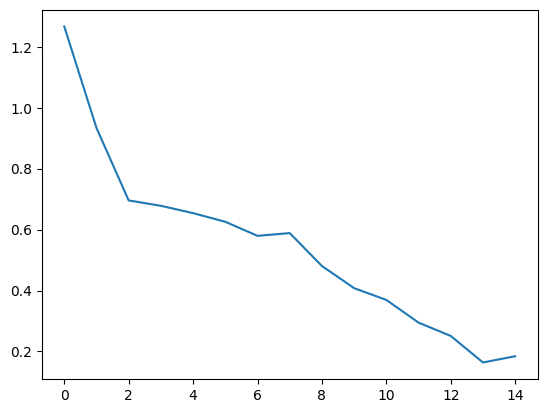

In [56]:
reset_seeds()
fitted_model = model_cat.fit(X_train_cat, y_train_cat, epochs=15, batch_size=32, callbacks=cb)
pd.Series(fitted_model.history['loss']).plot(label='train')

#### Dog model

In [46]:
model_dog = keras.Sequential([
    layers.Conv2D(16, kernel_size=(4, 4), activation='relu', input_shape=(100, 100, 3)),
    layers.Conv2D(16, kernel_size=(4, 4), activation='relu', input_shape=(100, 100, 3)),
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [47]:
model_dog.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_dog.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 97, 97, 16)        784       
                                                                 
 conv2d_10 (Conv2D)          (None, 94, 94, 16)        4112      
                                                                 
 conv2d_11 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 16)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 33856)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                2166848   
                                                      

Epoch 1/10


2023-07-08 17:19:40.197892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 115ms/step - loss: 0.7342 - accuracy: 0.5615
Epoch 2/10
6/6 [==============================] - 0s 33ms/step - loss: 0.6560 - accuracy: 0.6631
Epoch 3/10
6/6 [==============================] - 0s 31ms/step - loss: 0.6250 - accuracy: 0.7112
Epoch 4/10
6/6 [==============================] - 0s 30ms/step - loss: 0.5414 - accuracy: 0.7594
Epoch 5/10
6/6 [==============================] - 0s 32ms/step - loss: 0.4406 - accuracy: 0.8182
Epoch 6/10
6/6 [==============================] - 0s 31ms/step - loss: 0.3681 - accuracy: 0.8396
Epoch 7/10
6/6 [==============================] - 0s 32ms/step - loss: 0.2107 - accuracy: 0.9465
Epoch 8/10
6/6 [==============================] - 0s 30ms/step - loss: 0.1094 - accuracy: 0.9733
Epoch 9/10
6/6 [==============================] - 0s 30ms/step - loss: 0.0512 - accuracy: 0.9947
Epoch 10/10
6/6 [==============================] - 0s 29ms/step - loss: 0.0394 - accuracy: 0.9893


<Axes: >

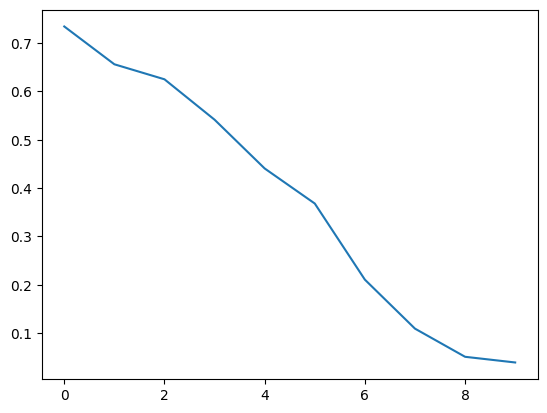

In [48]:
reset_seeds()
fitted_model = model_dog.fit(X_train_dog, y_train_dog, epochs=10, batch_size=32, callbacks=cb)
pd.Series(fitted_model.history['loss']).plot(label='train')

#### Combine 2 models

In [57]:
input_layer = tf.keras.layers.Input(shape=(100, 100, 3))

output_cat = model_cat(input_layer)
output_dog = model_dog(input_layer)

catdog_model = tf.keras.layers.concatenate([output_cat, output_dog])

catdog_model = tf.keras.Model(inputs=input_layer, outputs=catdog_model)

### Test

In [58]:
cats = X_train_cat[y_train_cat==1][0:5]
predictions_cat = catdog_model.predict(cats)
predictions_cat

1/1 [==============================] - 0s 92ms/step


2023-07-08 17:20:27.612494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[9.3182778e-01, 1.3779235e-01],
       [9.0367246e-01, 3.8256946e-01],
       [9.9672264e-01, 5.8779389e-01],
       [9.9993944e-01, 2.5816984e-05],
       [9.8010820e-01, 7.7243865e-01]], dtype=float32)

In [59]:
dogs = X_train_dog[y_train_dog==1][0:5]
predictions_dog = catdog_model.predict(dogs)
predictions_dog

1/1 [==============================] - 0s 12ms/step


array([[0.2663609 , 0.9809287 ],
       [0.3146687 , 0.99881554],
       [0.00690193, 0.9470975 ],
       [0.11347336, 0.97098666],
       [0.5382146 , 0.91120756]], dtype=float32)

## Model Evaluation:
Since our dataset is really small, so we test the `model_cat` on dog dataset and `model_dog` on cat dataset for a pseudo 'cross validation'.

In [60]:
# Compare the predictions
for i in range(len(predictions_cat)):
    prediction_cat, prediction_dog = predictions_cat[i]
    thr = 0.8
    dog_class = 1 if prediction_dog > thr else 0
    cat_class = 1 if prediction_cat > thr else 0
    print(i)
    if dog_class == 1 and cat_class == 1:
        print("Both models predict it's a dog and a cat")
    elif dog_class == 1:
        print("Model_dog predicts it's a dog")
    elif cat_class == 1:
        print("Model_cat predicts it's a cat")
    else:
        print("Both models predict it's neither a dog nor a cat")

print("***************************************")
for i in range(len(predictions_dog)):
    prediction_cat, prediction_dog = predictions_dog[i]
    thr = 0.8
    dog_class = 1 if prediction_dog > thr else 0
    cat_class = 1 if prediction_cat > thr else 0
    print(i)
    if dog_class == 1 and cat_class == 1:
        print("Both models predict it's a dog and a cat")
    elif dog_class == 1:
        print("Model_dog predicts it's a dog")
    elif cat_class == 1:
        print("Model_cat predicts it's a cat")
    else:
        print("Both models predict it's neither a dog nor a cat")


0
Model_cat predicts it's a cat
1
Model_cat predicts it's a cat
2
Model_cat predicts it's a cat
3
Model_cat predicts it's a cat
4
Model_cat predicts it's a cat
***************************************
0
Model_dog predicts it's a dog
1
Model_dog predicts it's a dog
2
Model_dog predicts it's a dog
3
Model_dog predicts it's a dog
4
Model_dog predicts it's a dog


# Conclusions:

As the test output of testing shows, the model can distinguish dogs and cats images nicely. The image below show the images that are used for the tesing above.

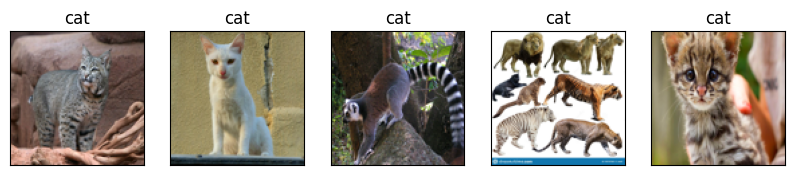

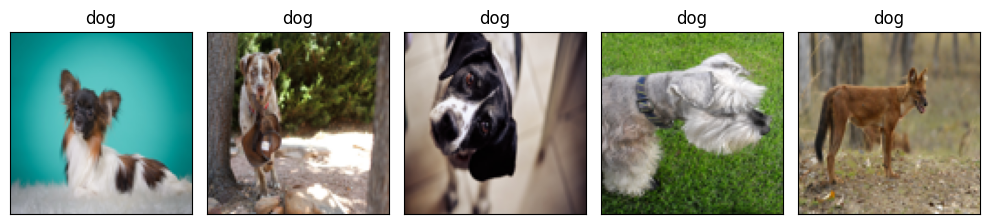

In [40]:
f, a = plt.subplots(nrows=1, ncols=5,figsize=(10, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(cats[i])
    ax.set_title('cat')

fd, ad = plt.subplots(nrows=1, ncols=5,figsize=(10, 6),
                      subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(ad.flat):
    ax.imshow(X_train_dog[y_train_dog==1][0:5][i])
    ax.set_title('dog')

plt.tight_layout()
plt.show()